### Case Study: Implementing GNN for Scheduling Optimization
Let’s assume a factory where multiple products are assembled using a variety of machines and operators. The challenge is to schedule tasks in a way that minimizes idle time and meets delivery deadlines. Here’s a step-by-step approach using GNN:

- Graph Construction: Build a graph where each node represents a task, and edges represent the sequence in which tasks must be performed. Include attributes like estimated task duration and resource requirements.
- Training the GNN: Use historical data to train the GNN on how different scheduling decisions have impacted productivity and deadlines in the past.
- Simulation and Optimization: Simulate different scheduling scenarios using the GNN. The network evaluates each scenario and provides feedback on its effectiveness in terms of productivity and resource utilization.
Implementation: Implement the optimal schedule suggested by the GNN, adjusting in real-time based on continuous feedback from the production floor.

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Step 1: Graph Construction
edges = torch.tensor([[0, 1], [1, 2], [1, 3], [2, 4], [3, 4]], dtype=torch.long).t()
node_features = torch.tensor([
    [10, 1],  # Task 0: Duration 10, Resource Requirement 1
    [20, 2],  # Task 1: Duration 20, Resource Requirement 2
    [15, 1],  # Task 2: Duration 15, Resource Requirement 1
    [10, 1],  # Task 3: Duration 10, Resource Requirement 1
    [5,  2]   # Task 4: Duration 5, Resource Requirement 2
], dtype=torch.float)

data = Data(x=node_features, edge_index=edges)

# Step 2: Define the GNN Model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_node_features)  # Output the same size as input features

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [14]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 3: Train the GNN
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.x)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss {loss.item()}')

Epoch 0: Loss 201.65020751953125
Epoch 10: Loss 90.29240417480469
Epoch 20: Loss 41.92975997924805
Epoch 30: Loss 21.05807113647461
Epoch 40: Loss 14.585969924926758
Epoch 50: Loss 14.870519638061523
Epoch 60: Loss 14.808591842651367
Epoch 70: Loss 14.415794372558594
Epoch 80: Loss 14.397071838378906
Epoch 90: Loss 14.392728805541992
Epoch 100: Loss 14.367022514343262
Epoch 110: Loss 14.359270095825195
Epoch 120: Loss 14.350667953491211
Epoch 130: Loss 14.341371536254883
Epoch 140: Loss 14.332636833190918
Epoch 150: Loss 14.323440551757812
Epoch 160: Loss 14.314046859741211
Epoch 170: Loss 14.304408073425293
Epoch 180: Loss 14.294517517089844
Epoch 190: Loss 14.284396171569824


In [16]:
# Step 4: Generate Schedule from GNN Output
def generate_schedule(task_durations, dependencies, resource_requirements):
    num_tasks = len(task_durations)
    start_times = np.zeros(num_tasks)
    finish_times = np.zeros(num_tasks)

    for i in range(num_tasks):
        if i == 0 or all(dependencies[:,1] != i):
            start_times[i] = 0  # Start the first task or tasks without dependencies immediately
        else:
            dependent_tasks = dependencies[:,0][dependencies[:,1] == i]
            start_times[i] = max([finish_times[j] for j in dependent_tasks])
        
        finish_times[i] = start_times[i] + task_durations[i]

    schedule = {f'Task {i}': (start_times[i], finish_times[i], resource_requirements[i]) for i in range(num_tasks)}
    return schedule

optimized_outputs = model(data).detach().numpy()
optimized_durations = optimized_outputs[:, 0]
resource_requirements = optimized_outputs[:, 1]
schedule = generate_schedule(optimized_durations, edges.numpy().T, resource_requirements)

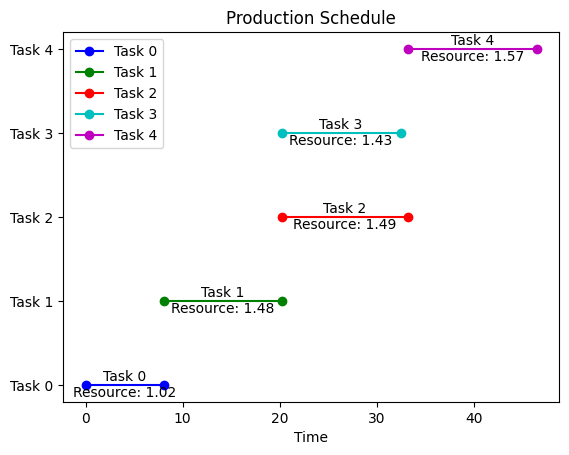

In [17]:
# Step 5: Visualize the Schedule
fig, ax = plt.subplots()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, (task, (start, end, resource)) in enumerate(schedule.items()):
    ax.plot([start, end], [i, i], marker='o', color=colors[i % len(colors)], label=task)
    ax.text((start + end)/2, i, f'{task}\nResource: {resource:.2f}', 
            horizontalalignment='center', verticalalignment='center')

ax.set_yticks(range(len(schedule)))
ax.set_yticklabels(schedule.keys())
ax.set_title('Production Schedule')
ax.set_xlabel('Time')
plt.legend()
plt.show()

In [20]:
print(model(data))
print('\n')
print(data.x)

tensor([[ 8.0722,  1.0211],
        [12.1126,  1.4831],
        [13.0687,  1.4930],
        [12.2577,  1.4306],
        [13.1918,  1.5698]], grad_fn=<AddBackward0>)


tensor([[10.,  1.],
        [20.,  2.],
        [15.,  1.],
        [10.,  1.],
        [ 5.,  2.]])
